In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install git+https://github.com/adam-coogan/jaxinterp2d.git
!pip install healpy


Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/adam-coogan/jaxinterp2d.git to /tmp/pip-req-build-pu6b_ot6
  Running command git clone --filter=blob:none --quiet https://github.com/adam-coogan/jaxinterp2d.git /tmp/pip-req-build-pu6b_ot6
  Resolved https://github.com/adam-coogan/jaxinterp2d.git to commit 98810756e69ffe0162defa8815383f858c57233a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

In [2]:
import jax

from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm

import matplotlib 
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

from jax.config import config
config.update("jax_enable_x64", True)
config.update('jax_default_matmul_precision', jax.lax.Precision.HIGHEST)

In [36]:
from jaxinterp2d import interp2d, CartesianGrid

zMax = 3
H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0
zres=12000

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value
zgrid = np.expm1(np.linspace(np.log(1), np.log(zMax+1), zres))

rs = []
Om0grid = jnp.linspace(0.2,0.4,50)
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

zgrid = jnp.array(zgrid)
rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

100%|██████████| 50/50 [00:00<00:00, 147.87it/s]


In [37]:
with h5py.File('/global/homes/w/wballard/standard-sirens/GW190412_selected_galaxies.hdf5', 'r') as inp:
    inp=inp['__astropy_table__']
    ras_ = np.array(inp['TARGET_RA'])
    decs_ = np.array(inp['TARGET_DEC'])
    zs_ = np.array(inp['Z'])
    ddzs_ = np.array(inp['ZERR'])

ngals = len(ras_)

n0fid = 0.002
print(n0fid)

0.002


(49152,)


100%|██████████| 49152/49152 [00:00<00:00, 206960.19it/s]


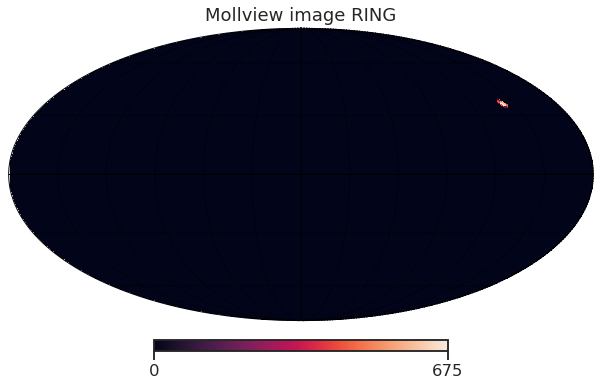

In [38]:
import healpy as hp

nside = 64
npix = hp.pixelfunc.nside2npix(nside)
apix = hp.pixelfunc.nside2pixarea(nside)
pixgrid = np.arange(npix)

print(pixgrid.shape)

ind = hp.pixelfunc.ang2pix(nside,ras_,decs_,lonlat=True)

cats = []
ngalaxies = []
for pix in tqdm(pixgrid):
    id = np.where(ind == pix)[0]
    cats.append(id)
    ngalaxies.append(len(id))

ngalaxies = np.array(ngalaxies)

m = np.asarray(ngalaxies)
hp.mollview(m, title="Mollview image RING")
hp.graticule()

In [39]:
deltafid = 3.0

@jit
def pcomplete(z,zgals,H0=H0Planck,Om0=Om0Planck,n0=n0fid,delta=deltafid):
    zz = jnp.expm1(jnp.linspace(jnp.log(1), jnp.log(z+1), 5))

    Ngals = jnp.where((zgals < z), jnp.ones(len(zgals)), 0).sum()
    Nexpected_fid = jnp.trapz(n0fid*(1+zz)**(delta-1)*apix*dV_of_z(zz,H0Planck,Om0),zz)

    Nexpected = Nexpected_fid*(n0/n0fid)*(H0Planck/H0)**3
    ratio = Ngals/Nexpected

    #ratio = jnp.where((ratio < 1), ratio, 0)
    #ratio = jnp.where((ratio != 0), ratio, 1)
    return ratio

pcomplete_vmap = jit(vmap(pcomplete, in_axes=(0,None,None,None,None,None), out_axes=0))

100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


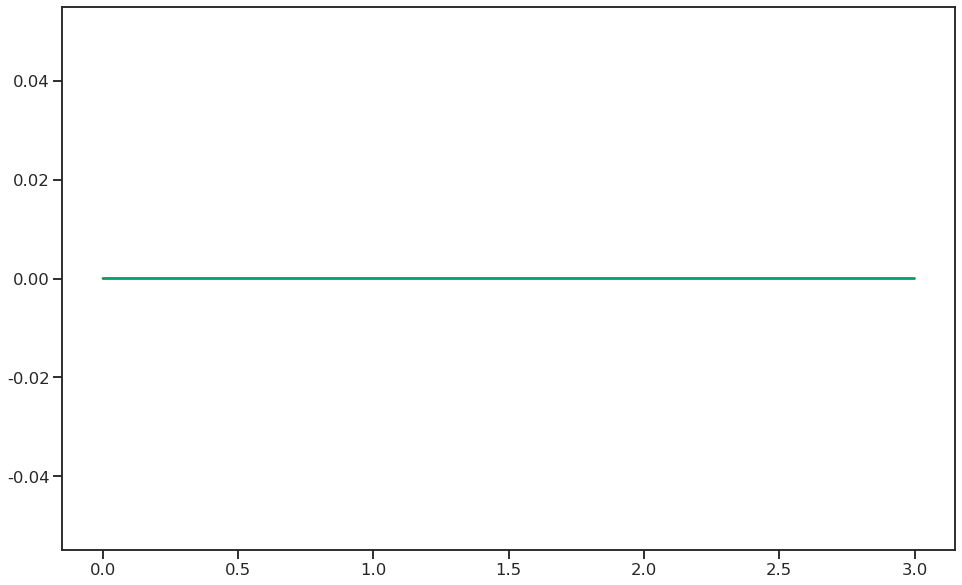

In [40]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

Pcompletes = []
for pix in tqdm(np.arange(3)):
    Pcomplete = pcomplete_vmap(zgrid, zs_[cats[pix]], 20, Om0Planck, n0fid/10, deltafid)
    #Pcomplete = jnp.where((Pcomplete < 1), Pcomplete, 0)
    #Pcomplete = jnp.where((Pcomplete != 0), Pcomplete, 1)
    Pcomplete = jnp.where(~jnp.isnan(Pcomplete), Pcomplete, 0)

    Pcompletes.append(Pcomplete)
    plt.plot(zgrid[1:],Pcomplete[1:])


In [41]:
@jit
def completeness_fraction(zgrid,zgals,H0=H0Planck,Om0=Om0Planck,n0=n0fid,delta=deltafid):
    Pcomplete = pcomplete_vmap(zgrid,zgals,H0Planck,Om0,n0fid,delta)
    Pcomplete = Pcomplete*(n0fid/n0)*(H0/H0Planck)**3

    #Pcomplete = jnp.where((Pcomplete < 1), Pcomplete, 0)
    #Pcomplete = jnp.where((Pcomplete != 0), Pcomplete, 1)
    Pcomplete = jnp.where(~jnp.isnan(Pcomplete), Pcomplete, 0)

    dVdz = dV_of_z(zgrid, H0Planck, Om0)*(1+zgrid)**(delta-1)

    V = jnp.trapz(Pcomplete*apix*dVdz,zgrid)
    Vmax = jnp.trapz(apix*dVdz,zgrid)

    return V/Vmax

f_Om0 = vmap(completeness_fraction, in_axes=(None,None,None,0,None,None), out_axes=0)
f_Om0_delta = vmap(f_Om0, in_axes=(None,None,None,None,None,0), out_axes=0)


In [42]:
deltagrid = jnp.linspace(0,3,50)
fs = []

pixgrid = jnp.arange(npix)
for pix in tqdm(pixgrid):
    idx = cats[pix]
    if (len(idx) == 0):
        f = jnp.zeros((len(deltagrid),len(Om0grid)))
    else:
        f = f_Om0_delta(zgrid,zs_[idx],H0Planck,Om0grid,n0fid,deltagrid)
    fs.append(f)

fs = jnp.asarray(fs)

100%|██████████| 49152/49152 [00:41<00:00, 1177.40it/s]


In [43]:
from jaxinterp2d import interp2d, CartesianGrid

pixgrid = jnp.array(pixgrid)

limits = [(pixgrid[0], pixgrid[-1]), (Om0grid[0], Om0grid[-1]), (deltagrid[0], deltagrid[-1])]
grid = CartesianGrid(limits, fs, mode='nearest')

@jit
def completeness_fraction(H0,Om0,n0,delta,pix):
    return grid(pix,Om0,delta)*(n0fid/n0)*(H0/H0Planck)**3

In [44]:
from jax.scipy.stats import norm

@jit
def pcatalog(z, zs, ddzs):
    ns = len(z)
    ngals = len(zs)
    wts = 1/ngals
    pdf = jnp.sum(wts*norm.pdf(jnp.repeat(z,ngals),jnp.tile(zs,ns),jnp.tile(ddzs,ns)).reshape(ns,ngals),axis=1)
    return pdf

pcatalogs = []
for pix in tqdm(pixgrid):
    idx = cats[pix]
    if (len(idx) == 0):
        prob = jnp.zeros(len(zgrid))
    else:
        prob = pcatalog(zgrid, zs_[idx], ddzs_[idx])
    #plt.plot(zgrid,prob)
    pcatalogs.append(prob)

100%|██████████| 49152/49152 [00:11<00:00, 4420.95it/s]


In [45]:
from jaxinterp2d import interp2d

vals = jnp.asarray(pcatalogs)
vv = vals.reshape(len(pixgrid),len(zgrid))

@jit
def dV_of_z_normed(z,Om0,gamma):
    dV = dV_of_z(z,H0Planck,Om0)*(1+z)**(gamma-1)
    return dV/jnp.trapz(dV,z)

@jit
def PriorUniverse(z,pix,H0,Om0,n0,delta,gamma):
    f = completeness_fraction(H0,Om0,n0,delta,pix)
    prob = (f*interp2d(pix,zgrid,pixgrid,zgrid,vv) + (1-f)*dV_of_z_normed(zgrid,Om0,gamma))
    prob = prob/jnp.trapz(prob,zgrid)
    return jnp.interp(z,zgrid,prob)

@jit
def PriorUniverse_TEST(z,pix,H0,Om0,n0,delta,gamma):
    f = completeness_fraction(H0,Om0,n0,delta,pix)
    pvol = dV_of_z_normed(zgrid,Om0,1)
    pcat = interp2d(pix,zgrid,pixgrid,zgrid,vv)*pvol
    pcat = pcat/jnp.trapz(pcat,zgrid)
    pcat = jnp.where(~jnp.isnan(pcat), pcat, 0)
    prob = (f*pcat + (1-f)*pvol)*(1+zgrid)**(gamma-1)
    prob = prob/jnp.trapz(prob,zgrid)
    return jnp.interp(z,zgrid,prob)

PriorUniverse_vmap = jit(vmap(PriorUniverse_TEST, in_axes=(None,0,None,None,None,None,None), out_axes=0))

In [46]:
import h5py
with h5py.File('/global/homes/w/wballard/standard-sirens/standard-sirens'+str(nside)+'_'+str(zres)+'_approx.h5', 'w') as f:
    f.attrs['nside'] = nside
    f.attrs['n0fid'] = n0fid
    f.attrs['H0fid'] = H0Planck
    f.create_dataset('zgrid', data=zgrid, compression='gzip', shuffle=False)
    f.create_dataset('Om0grid', data=Om0grid, compression='gzip', shuffle=False)
    f.create_dataset('deltagrid', data=deltagrid, compression='gzip', shuffle=False)
    f.create_dataset('fs', data=fs, compression='gzip', shuffle=False)
    f.create_dataset('pcat', data=vals, compression='gzip', shuffle=False)

In [ ]:
for pix in pixgrid:
    prob = PriorUniverse(zgrid,pix,H0Planck,Om0Planck,n0fid,0,0)
    plt.plot(zgrid,prob)

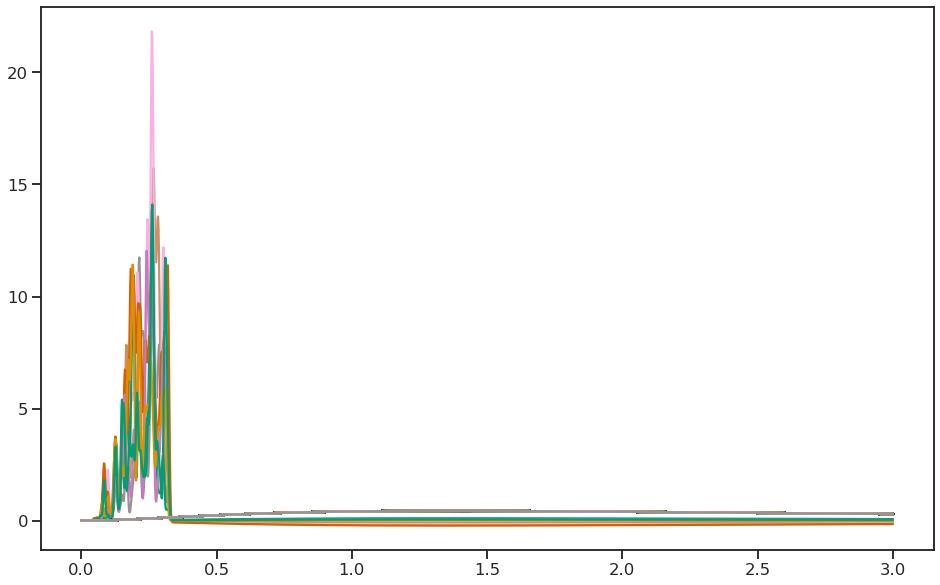

In [14]:
for pix in pixgrid:
    prob = PriorUniverse_TEST(zgrid,pix,H0Planck,Om0Planck,n0fid/100,0,0)
    plt.plot(zgrid,prob)